**Import dataset from kaggle**

In [ ]:
from google.colab import userdata
username = userdata.get('KAGGLE_USER')
key = userdata.get('KAGGLE_KEY')
# Echo the credentials into the kaggle.json file
!mkdir -p ~/.kaggle
!echo '{{"username":"{username}","key":"{key}"}}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d senuraperera/knee-oa-new -p Dataset
!unzip "Dataset/*.zip" -d Dataset
!rm Dataset/*.zip

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: Dataset/input_com/train/2/9762973L.png  
  inflating: Dataset/input_com/train/2/9766202R.png  
  inflating: Dataset/input_com/train/2/9767446L.png  
  inflating: Dataset/input_com/train/2/9769470L.png  
  inflating: Dataset/input_com/train/2/9769470R.png  
  inflating: Dataset/input_com/train/2/9770472L.png  
  inflating: Dataset/input_com/train/2/9770472R.png  
  inflating: Dataset/input_com/train/2/9771727L.png  
  inflating: Dataset/input_com/train/2/9771973L.png  
  inflating: Dataset/input_com/train/2/9772225R.png  
  inflating: Dataset/input_com/train/2/9774237L.png  
  inflating: Dataset/input_com/train/2/9774237R.png  
  inflating: Dataset/input_com/train/2/9777777R.png  
  inflating: Dataset/input_com/train/2/9778518R.png  
  inflating: Dataset/input_com/train/2/9779490L.png  
  inflating: Dataset/input_com/train/2/9779490R.png  
  inflating: Dataset/input_com/train/2/9780662L.png  
  inflating: Dataset/inpu

**Import library**

In [ ]:
!pip install -q fastbook
from fastbook import *
from torchvision import transforms
!pip install timm
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.3 MB/s eta 0:00:00


**Create datablock**

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(valid_name='val'),
    get_y=parent_label,
    item_tfms=Resize(224)
    )
dls = dblock.dataloaders('/content/Dataset/input_com', bs=64)


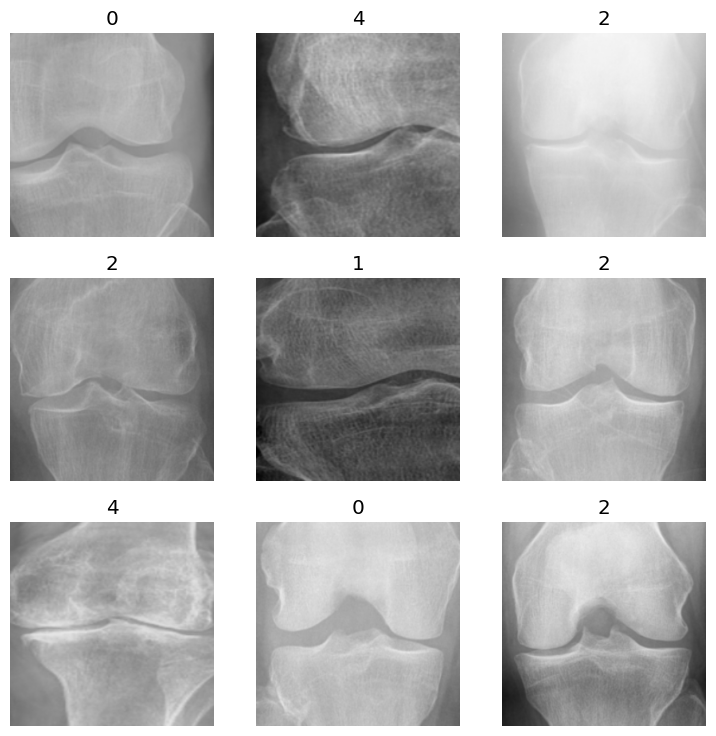

In [ ]:
dls.train.show_batch(max_n=9,nrows=3)

**Define model**

In [ ]:
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=dls.c)
for param in model.parameters():
    param.requires_grad = False
num_inputs = model.head.in_features
last_layer = nn.Linear(num_inputs, dls.c)
model.head = last_layer

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

**Train**

In [ ]:
learn = Learner(dls, model, metrics=accuracy)

learn.fine_tune(epochs=20, freeze_epochs=1, base_lr=2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.336152,1.100179,0.593676,01:57


epoch,train_loss,valid_loss,accuracy,time
0,1.169803,1.069599,0.591636,02:01
1,1.151136,1.042287,0.595036,02:01
2,1.134212,1.000953,0.599116,02:02
3,1.110648,0.968226,0.624277,02:02
4,1.101173,0.937447,0.639918,02:01
5,1.078644,0.950765,0.616457,02:00
6,1.059343,0.911066,0.649779,02:00
7,1.050504,0.891038,0.655559,02:00
8,1.035838,0.894228,0.668820,02:00
9,1.030511,0.904657,0.631758,02:00


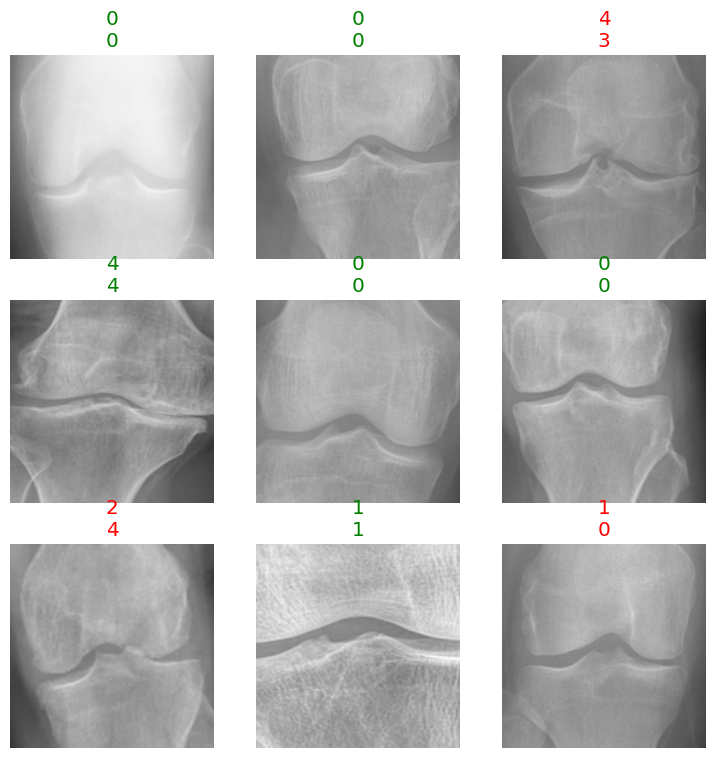

In [ ]:
learn.show_results() #true label - บน; prediction - ล่าง

**Evaluate from validation set**

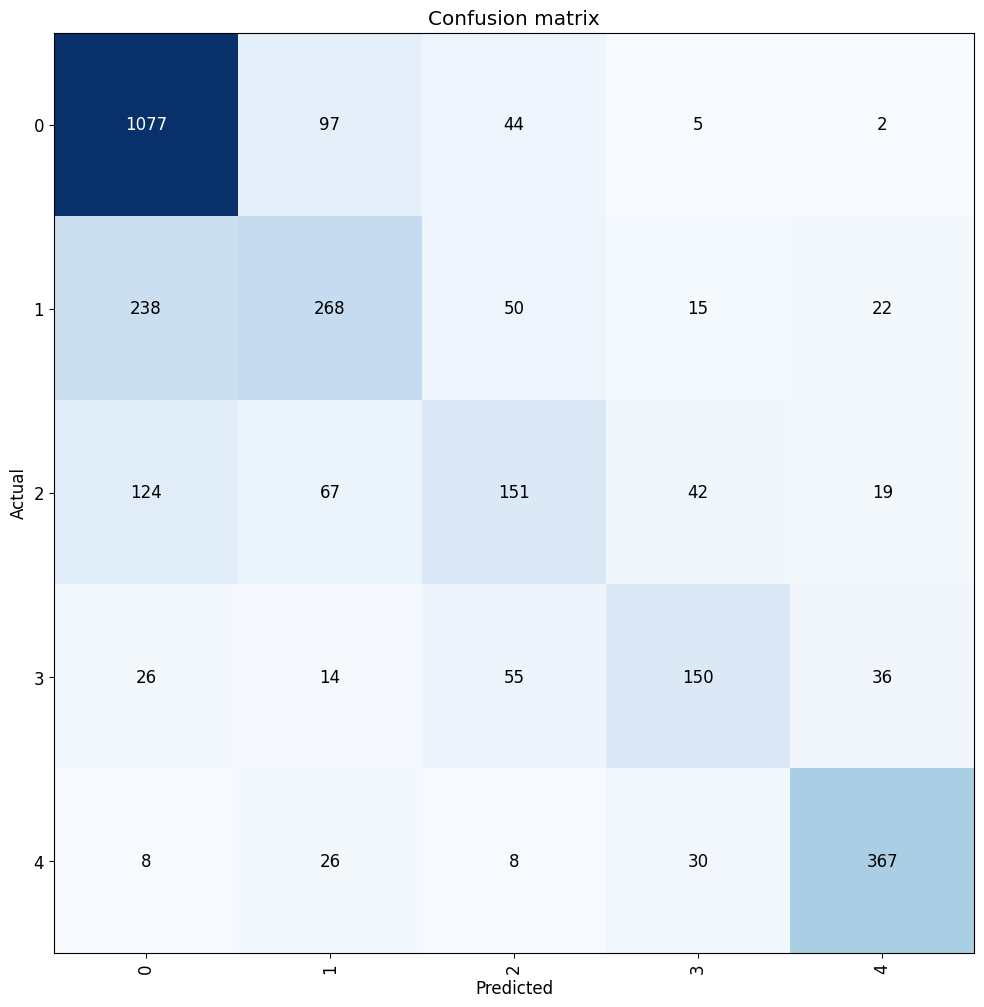

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

In [ ]:
interp.print_classification_report()

              precision    recall  f1-score   support

           0       0.73      0.88      0.80      1225
           1       0.57      0.45      0.50       593
           2       0.49      0.37      0.42       403
           3       0.62      0.53      0.57       281
           4       0.82      0.84      0.83       439

    accuracy                           0.68      2941
   macro avg       0.65      0.62      0.63      2941
weighted avg       0.67      0.68      0.67      2941



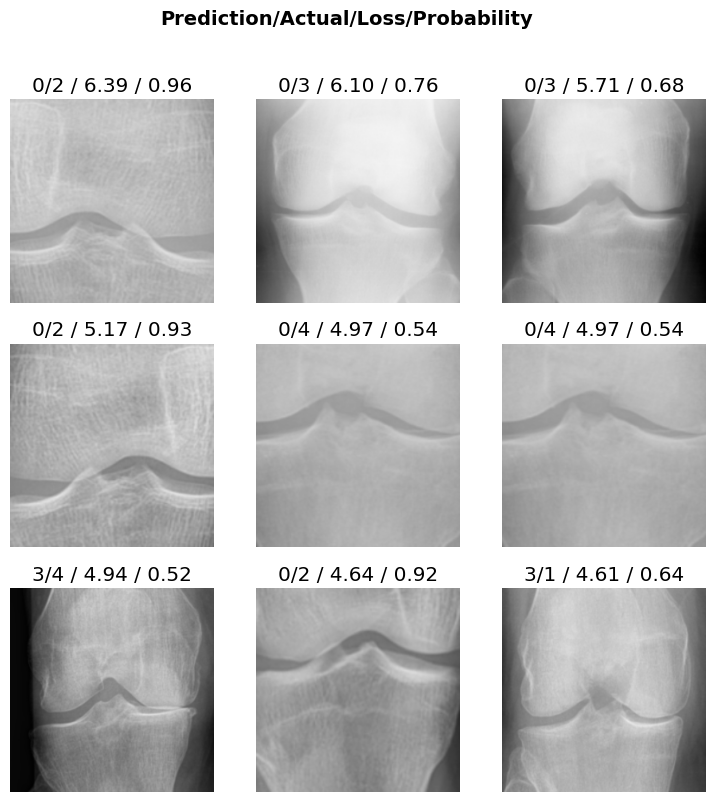

In [ ]:
iinterp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

In [ ]:
learn.export('fine_tuned_vitl')

**Visualize attention**

In [ ]:
learn = load_learner('fine_tuned_vitl')

model = learn.model

In [ ]:
def show_img(img):
    img = np.asarray(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

attn_map shape: torch.Size([197, 197])
cls_weight shape: torch.Size([1, 195])
Image resized shape: torch.Size([224, 224, 3])
Class attention map resized shape: torch.Size([224, 224])


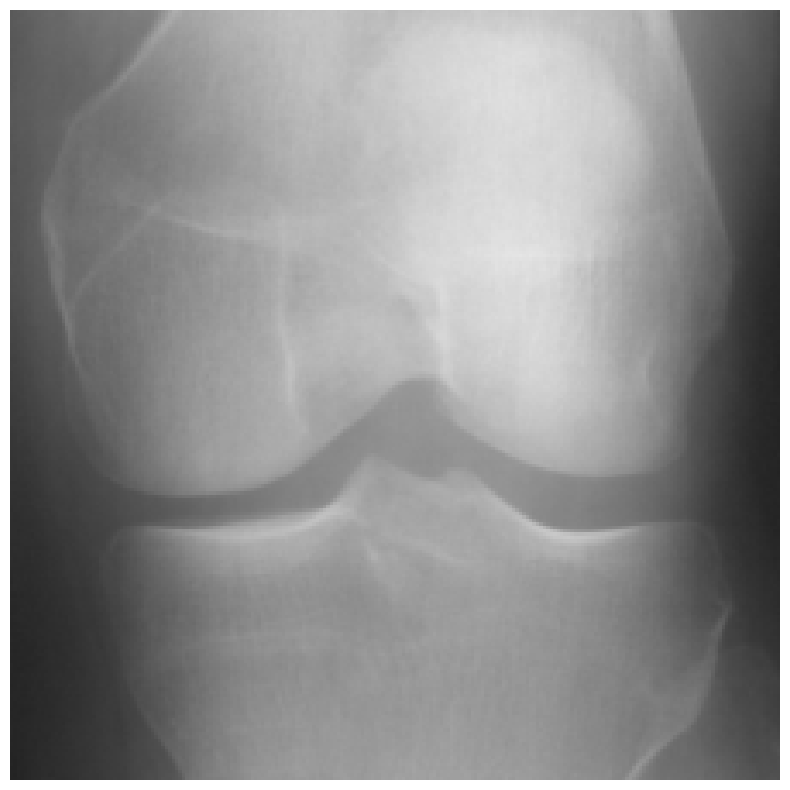

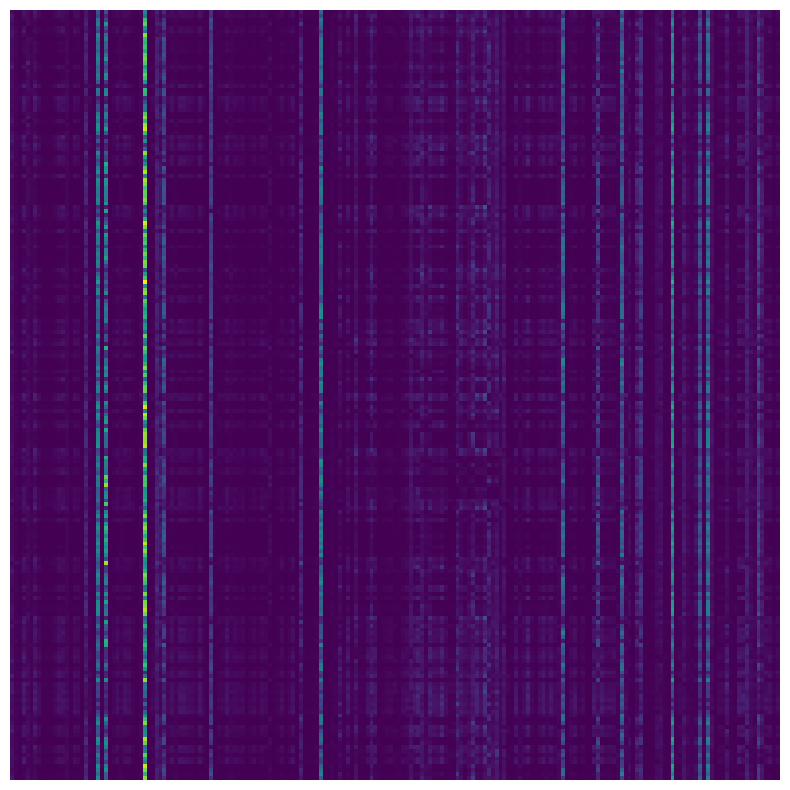

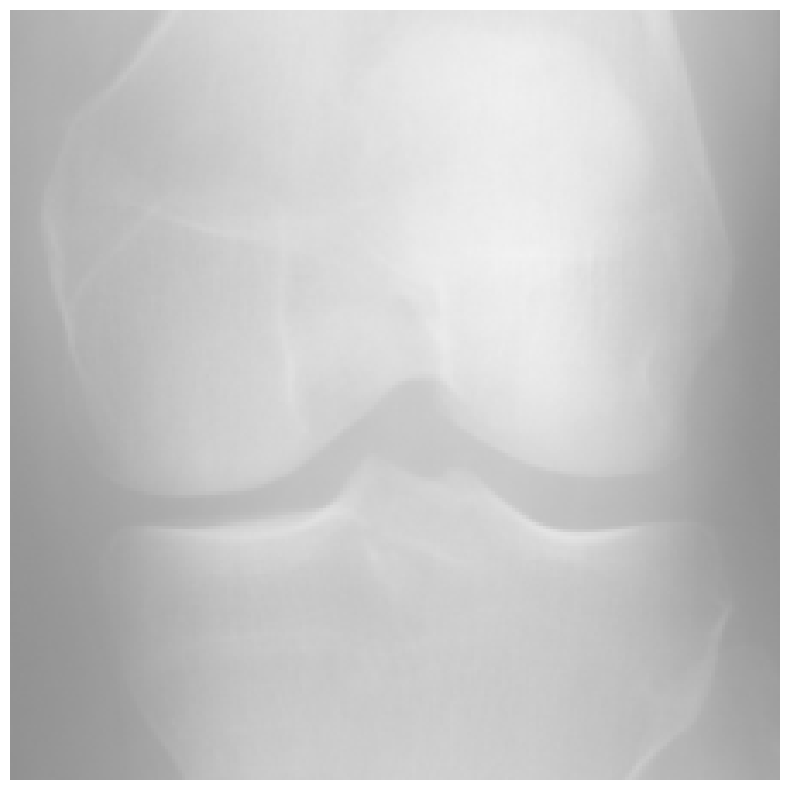

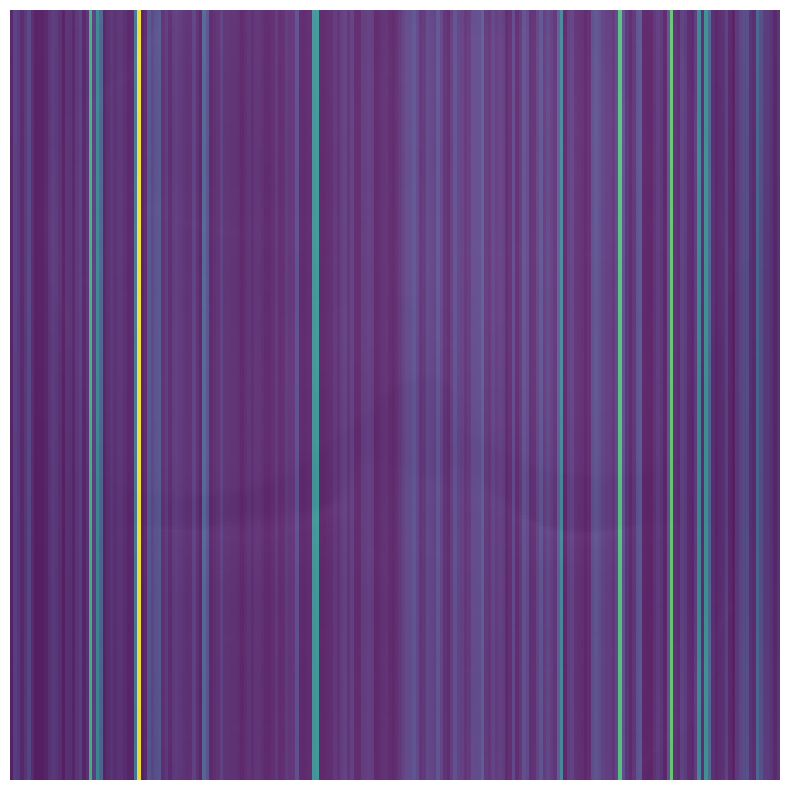

In [ ]:
#0
img = Image.open('/content/Dataset/input_com/train/0/9001695L.png').convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_tensor = transform(img)

model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)

img_tensor = img_tensor.unsqueeze(0)

y = model(img_tensor)

attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).detach()

print("attn_map shape:", attn_map.shape)
print("cls_weight shape:", cls_weight.shape)

cls_resized = F.interpolate(cls_weight.unsqueeze(0).unsqueeze(0), (224, 224), mode='bilinear').squeeze(0).squeeze(0)

img_resized = img_tensor.squeeze(0).permute(1, 2, 0) * 0.5 + 0.5

print("Image resized shape:", img_resized.shape)
print("Class attention map resized shape:", cls_resized.shape)

show_img(img)
show_img(attn_map)
show_img(cls_weight)
show_img(img_resized)
show_img2(img_resized, cls_resized, alpha=0.8)

attn_map shape: torch.Size([197, 197])
cls_weight shape: torch.Size([1, 195])
Image resized shape: torch.Size([224, 224, 3])
Class attention map resized shape: torch.Size([224, 224])


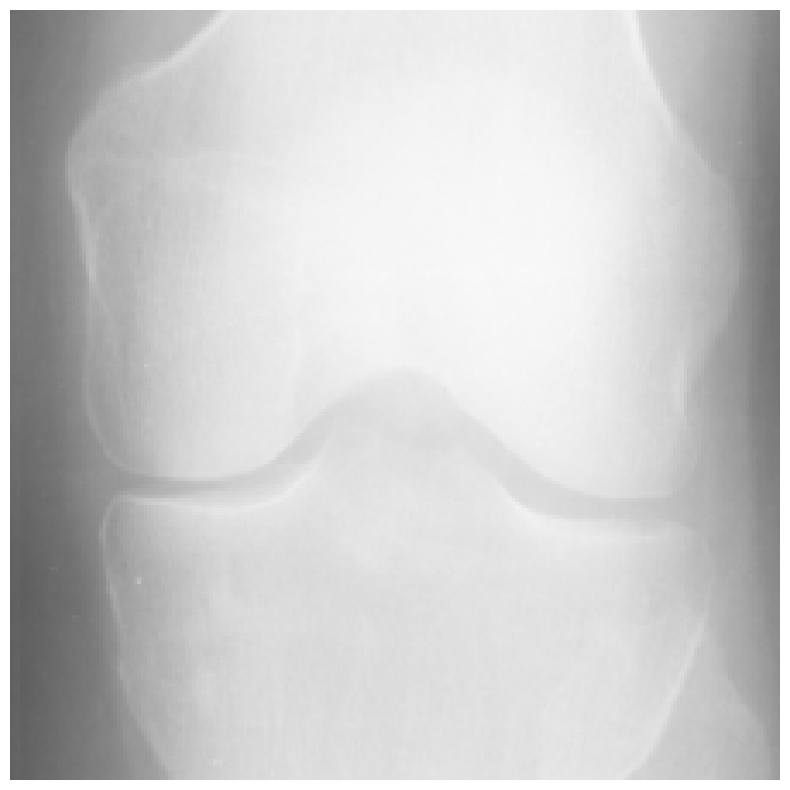

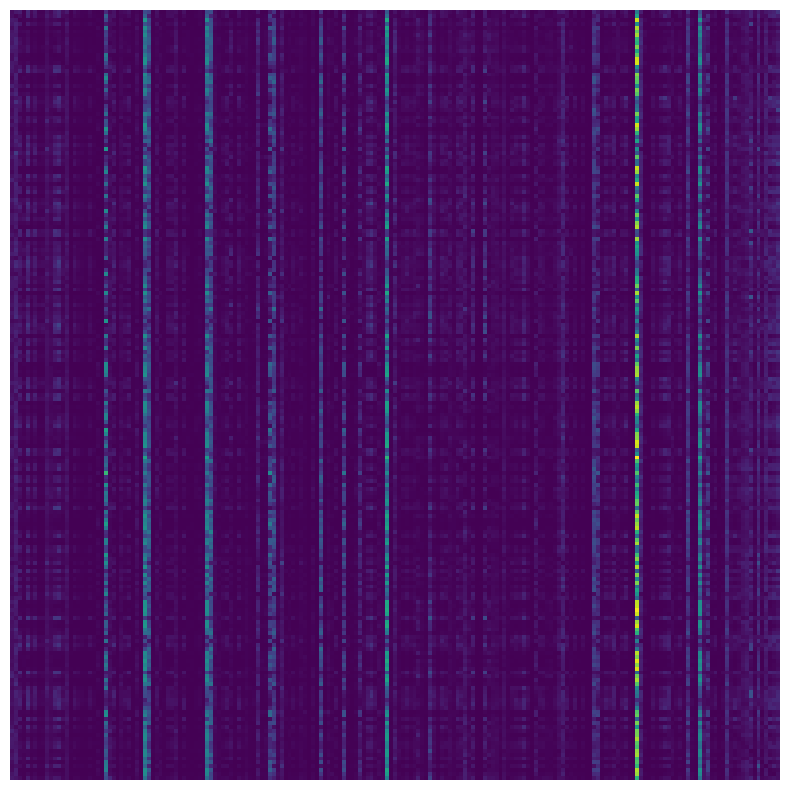

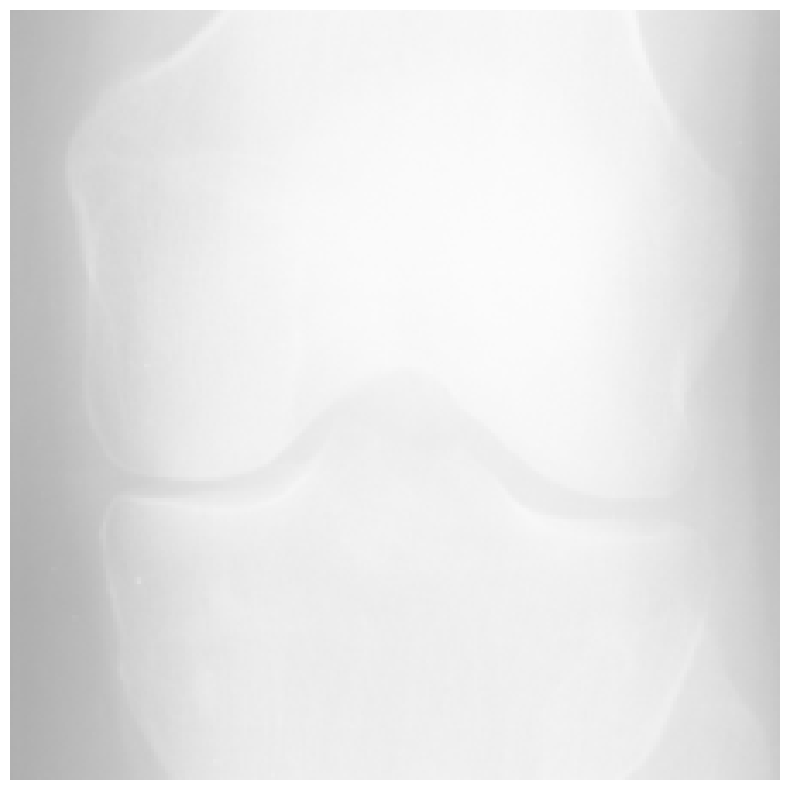

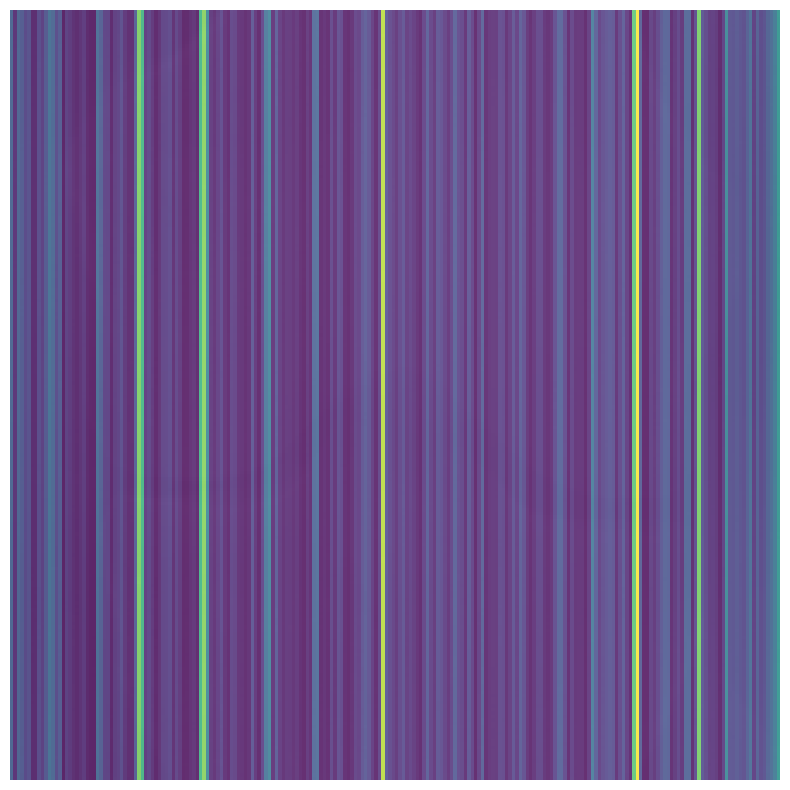

In [ ]:
#1
img = Image.open('/content/Dataset/input_com/train/1/9000622L.png').convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_tensor = transform(img)

model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)

img_tensor = img_tensor.unsqueeze(0)

y = model(img_tensor)

attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).detach()

print("attn_map shape:", attn_map.shape)
print("cls_weight shape:", cls_weight.shape)

cls_resized = F.interpolate(cls_weight.unsqueeze(0).unsqueeze(0), (224, 224), mode='bilinear').squeeze(0).squeeze(0)

img_resized = img_tensor.squeeze(0).permute(1, 2, 0) * 0.5 + 0.5

print("Image resized shape:", img_resized.shape)
print("Class attention map resized shape:", cls_resized.shape)

show_img(img)
show_img(attn_map)
show_img(cls_weight)
show_img(img_resized)
show_img2(img_resized, cls_resized, alpha=0.8)

attn_map shape: torch.Size([197, 197])
cls_weight shape: torch.Size([1, 195])
Image resized shape: torch.Size([224, 224, 3])
Class attention map resized shape: torch.Size([224, 224])


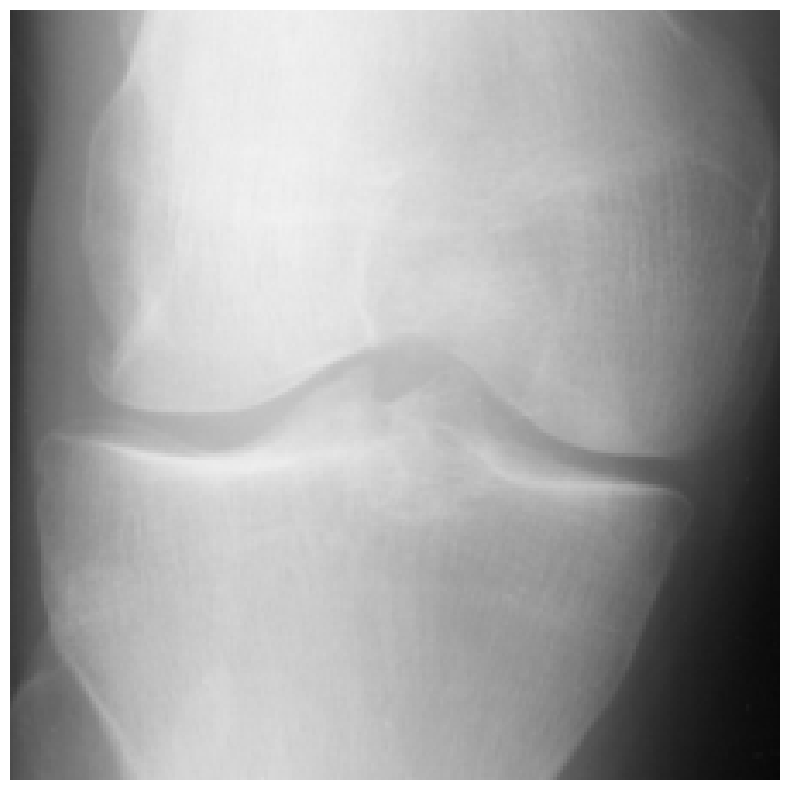

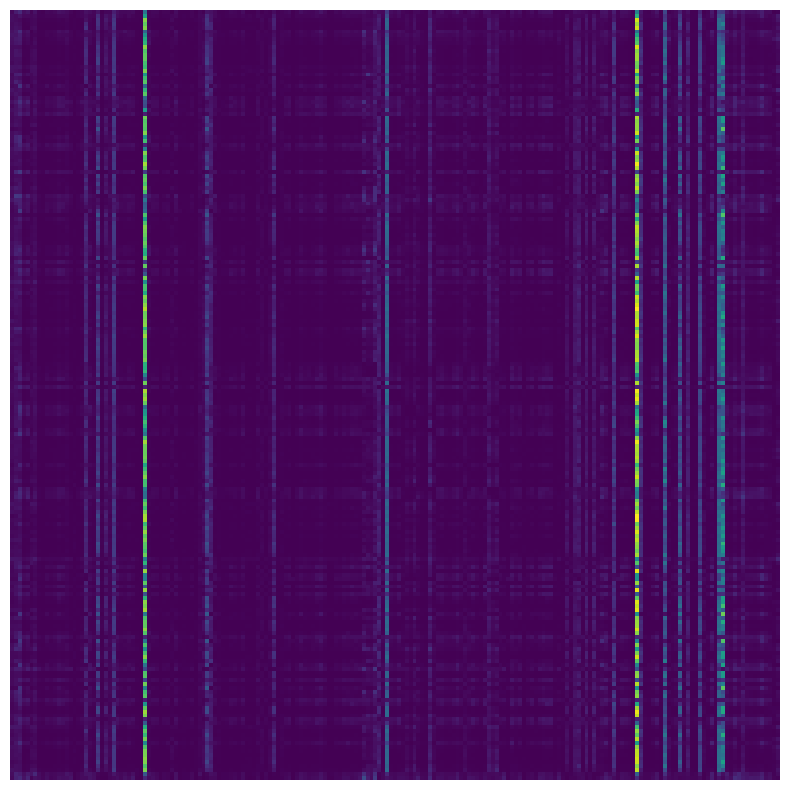

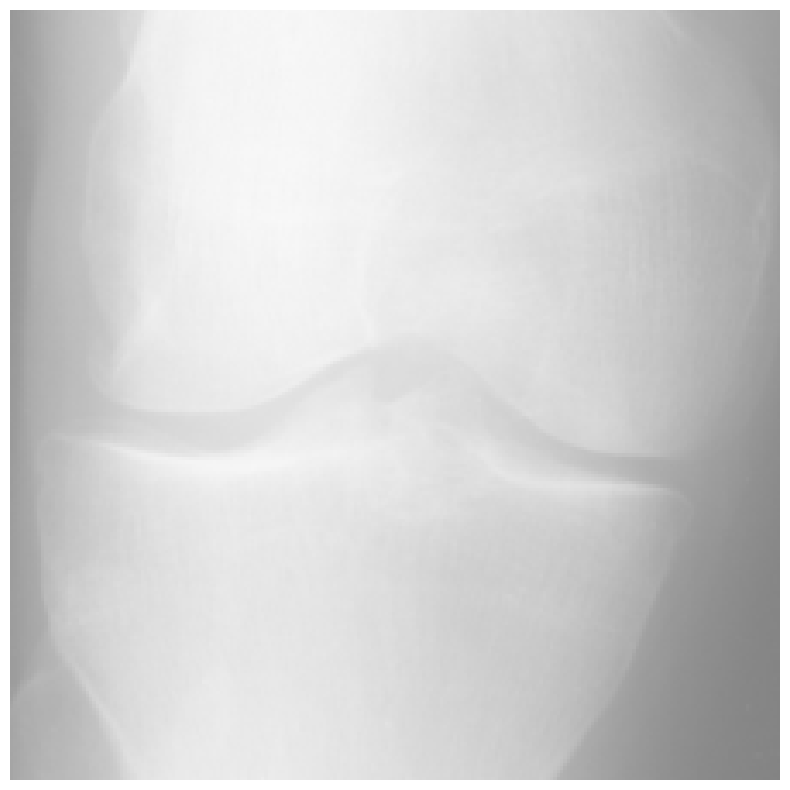

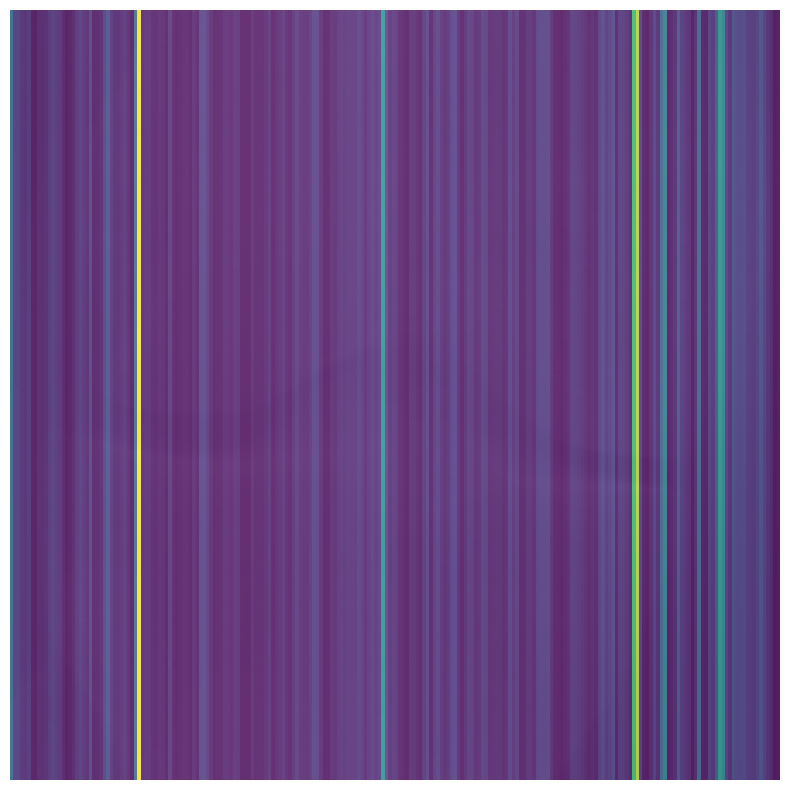

In [ ]:
#2
img = Image.open('/content/Dataset/input_com/train/2/9000099R.png').convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_tensor = transform(img)

model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)

img_tensor = img_tensor.unsqueeze(0)

y = model(img_tensor)

attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).detach()

print("attn_map shape:", attn_map.shape)
print("cls_weight shape:", cls_weight.shape)

cls_resized = F.interpolate(cls_weight.unsqueeze(0).unsqueeze(0), (224, 224), mode='bilinear').squeeze(0).squeeze(0)

img_resized = img_tensor.squeeze(0).permute(1, 2, 0) * 0.5 + 0.5

print("Image resized shape:", img_resized.shape)
print("Class attention map resized shape:", cls_resized.shape)

show_img(img)
show_img(attn_map)
show_img(cls_weight)
show_img(img_resized)
show_img2(img_resized, cls_resized, alpha=0.8)

attn_map shape: torch.Size([197, 197])
cls_weight shape: torch.Size([1, 195])
Image resized shape: torch.Size([224, 224, 3])
Class attention map resized shape: torch.Size([224, 224])


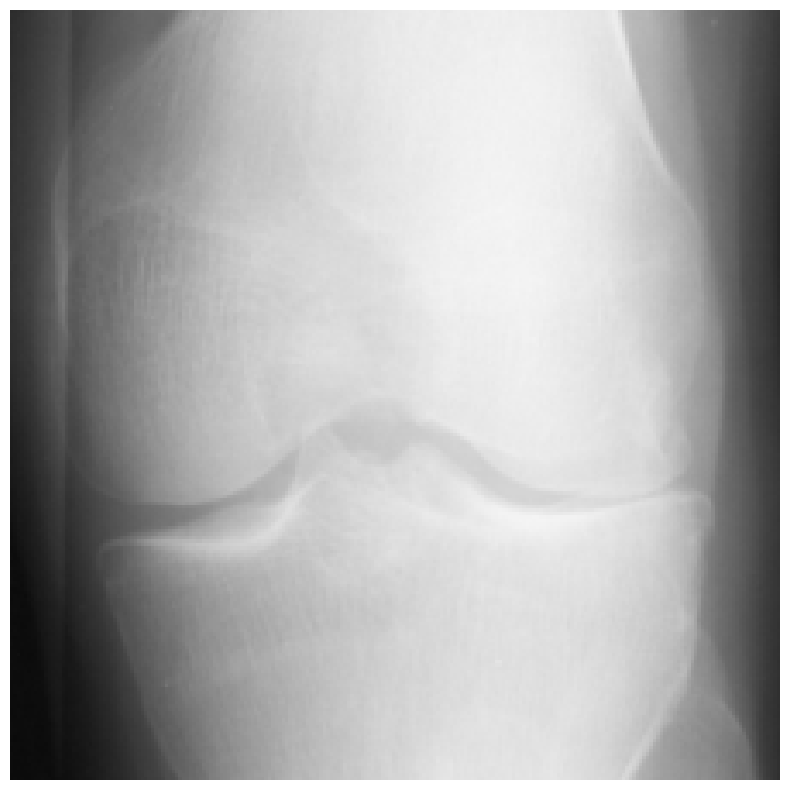

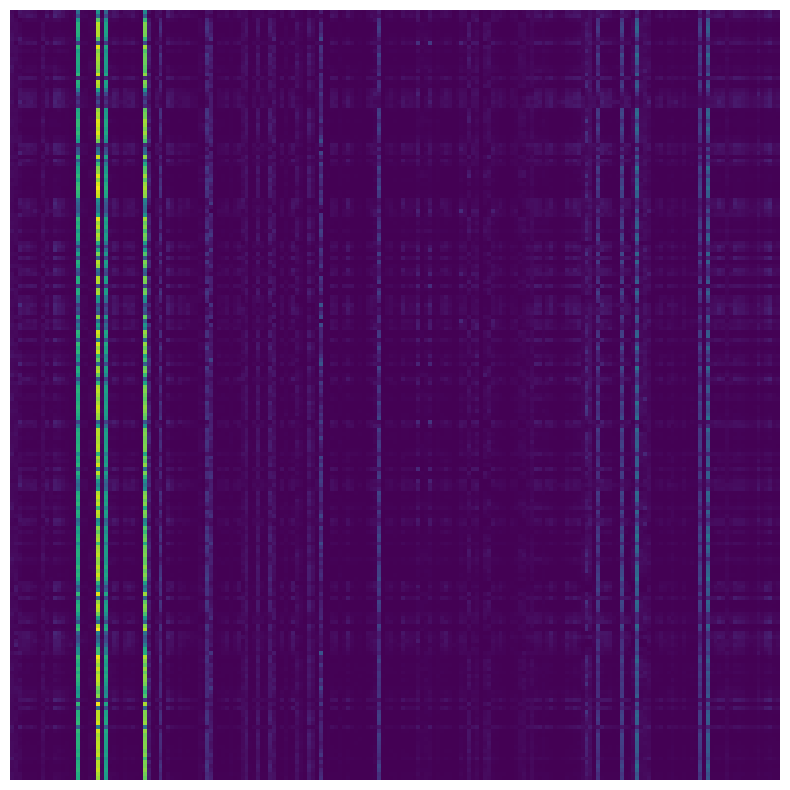

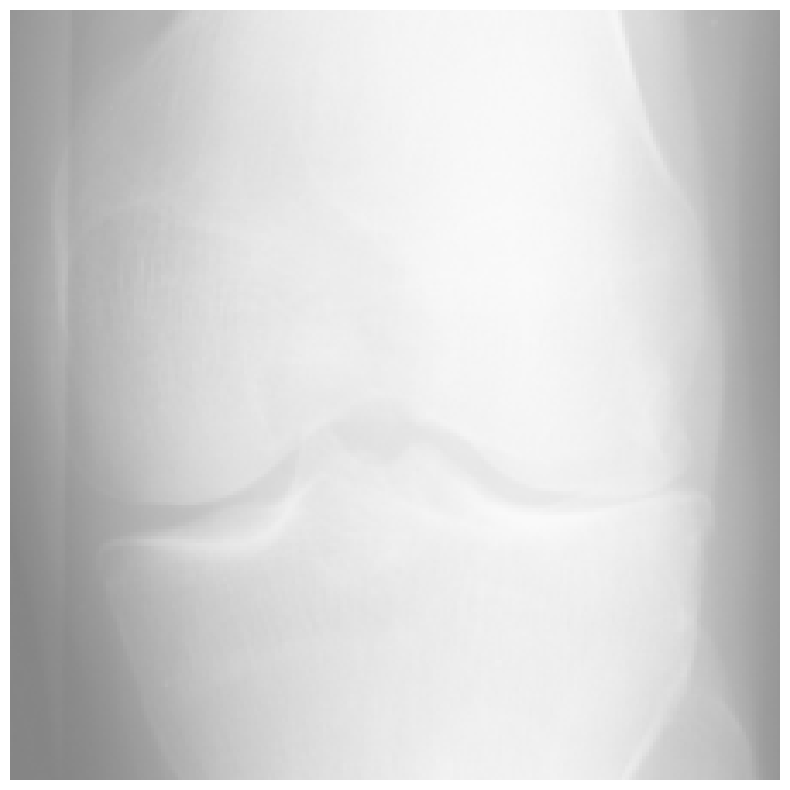

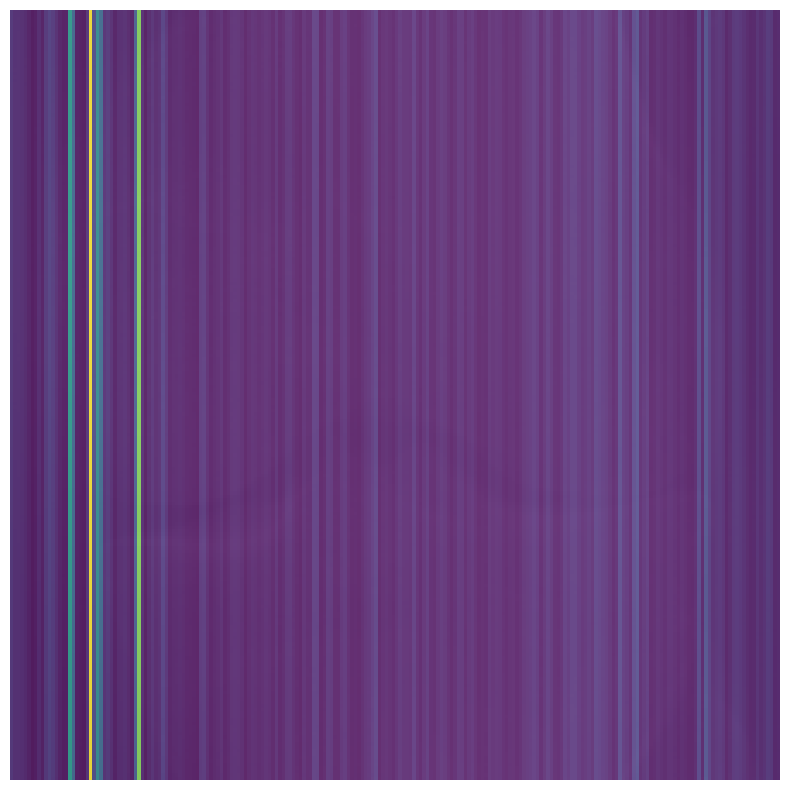

In [ ]:
#3
img = Image.open('/content/Dataset/input_com/train/3/9000099L.png').convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_tensor = transform(img)

model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)

img_tensor = img_tensor.unsqueeze(0)

y = model(img_tensor)

attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).detach()

print("attn_map shape:", attn_map.shape)
print("cls_weight shape:", cls_weight.shape)

cls_resized = F.interpolate(cls_weight.unsqueeze(0).unsqueeze(0), (224, 224), mode='bilinear').squeeze(0).squeeze(0)

img_resized = img_tensor.squeeze(0).permute(1, 2, 0) * 0.5 + 0.5

print("Image resized shape:", img_resized.shape)
print("Class attention map resized shape:", cls_resized.shape)

show_img(img)
show_img(attn_map)
show_img(cls_weight)
show_img(img_resized)
show_img2(img_resized, cls_resized, alpha=0.8)

attn_map shape: torch.Size([197, 197])
cls_weight shape: torch.Size([1, 195])
Image resized shape: torch.Size([224, 224, 3])
Class attention map resized shape: torch.Size([224, 224])


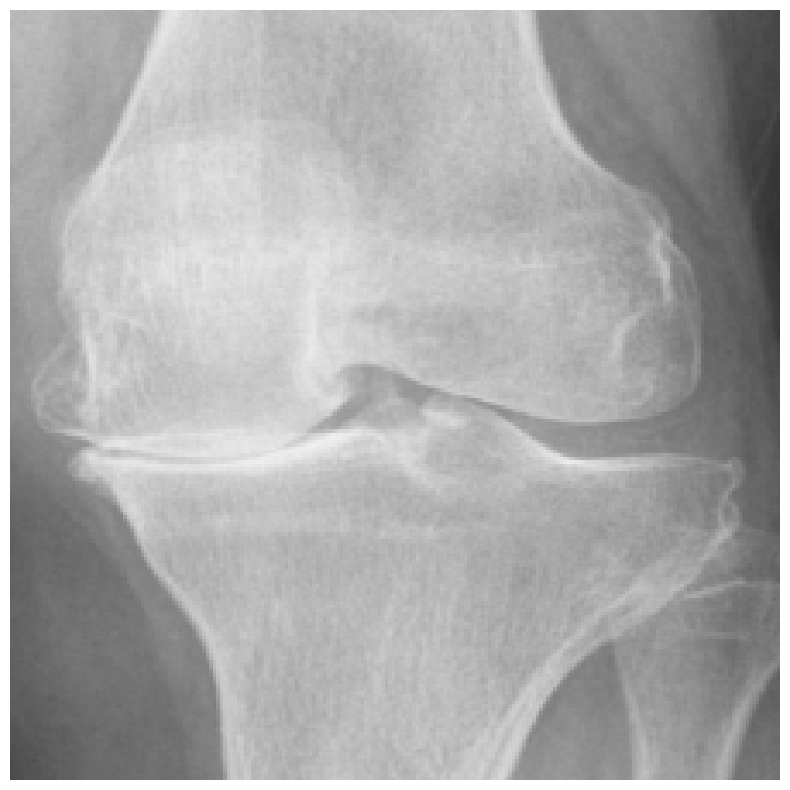

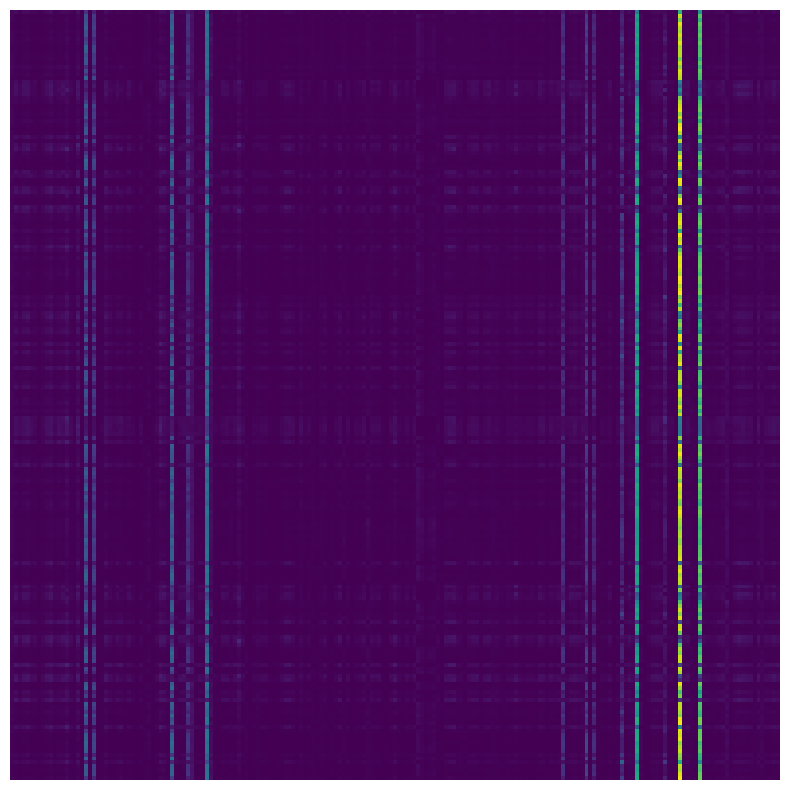

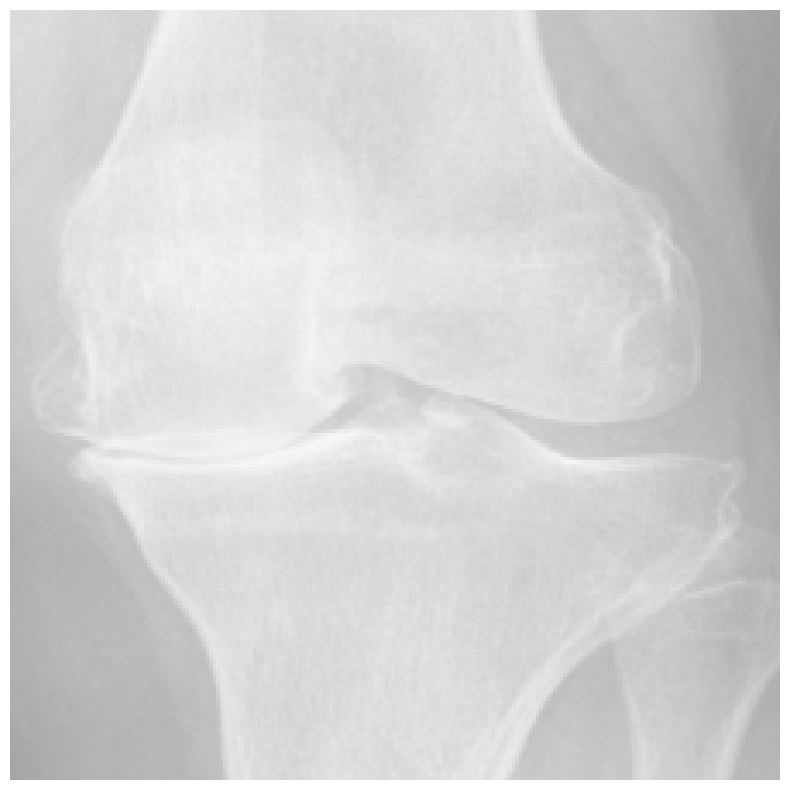

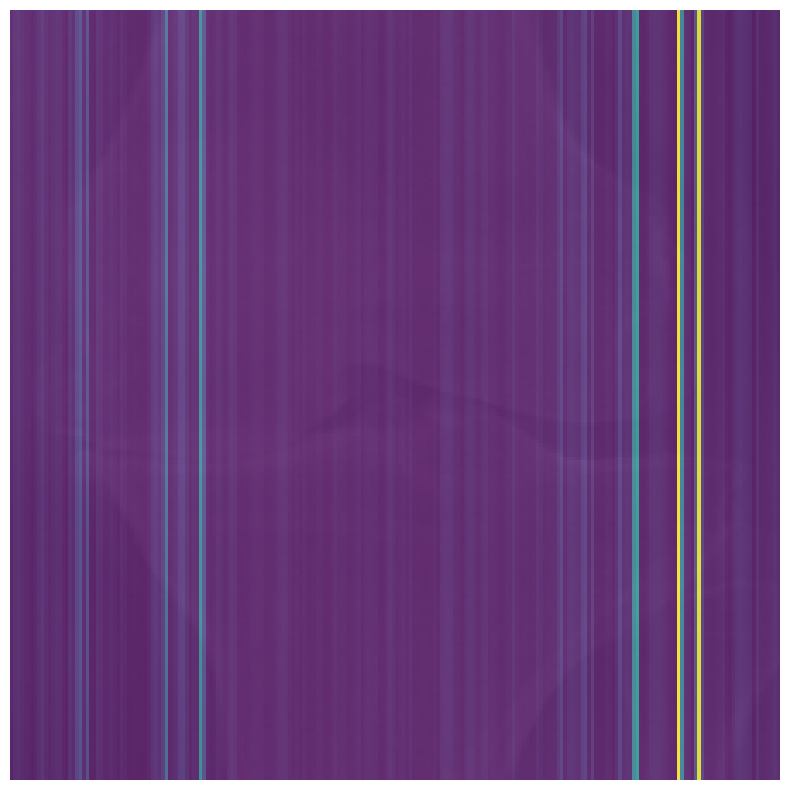

In [ ]:
#4
img = Image.open('/content/Dataset/input_com/train/4/9025994L.png').convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_tensor = transform(img)

model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)

img_tensor = img_tensor.unsqueeze(0)

y = model(img_tensor)

attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).detach()

print("attn_map shape:", attn_map.shape)
print("cls_weight shape:", cls_weight.shape)

cls_resized = F.interpolate(cls_weight.unsqueeze(0).unsqueeze(0), (224, 224), mode='bilinear').squeeze(0).squeeze(0)

img_resized = img_tensor.squeeze(0).permute(1, 2, 0) * 0.5 + 0.5

print("Image resized shape:", img_resized.shape)
print("Class attention map resized shape:", cls_resized.shape)

show_img(img)
show_img(attn_map)
show_img(cls_weight)
show_img(img_resized)
show_img2(img_resized, cls_resized, alpha=0.8)